## Importing relevant libraries

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.spatial as spat
from scipy.stats import unitary_group
from scipy.stats import moment
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from scipy.linalg import norm
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass

# Libraries for implementing the VQD algorithm
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.primitives import Sampler, Estimator
from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, TwoLocal, EfficientSU2
from qiskit_algorithms.optimizers import *
from qiskit_algorithms.state_fidelities import ComputeUncompute

from qiskit_algorithms.eigensolvers import EigensolverResult, VQD
from qiskit_algorithms import NumPyMinimumEigensolver, VQE

# Import classical optimizers
from qiskit_algorithms.optimizers import SPSA, P_BFGS, COBYLA, IMFIL, SNOBFIT, NELDER_MEAD, SLSQP, NFT, ADAM, POWELL, GradientDescent, BOBYQA

# Import Statevector and SparsePauliOp
from qiskit.quantum_info import SparsePauliOp, Statevector

# Import noise models
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# Import a fake backend and Qiskit simulators and/or noise libraries
from qiskit_aer import AerSimulator
# from qiskit_aer.primitives import Estimator as AerEstimator 
# from qiskit_aer.noise import NoiseModel

## Constructing the Schlogl operator

In [3]:
def TridiagA(lambda_func, mu_func, N):
    """
    Creates tridiagonal stochastic matrix for the Schlogl model
    Inputs lambda and mu model functions, and N desired size of matrix
    Returns stochastic matrix (non-hermitian)
    """
    # initialize diagonals
    d1 = np.zeros(N - 1)
    d2 = np.zeros(N)
    d3 = np.zeros(N - 1)

    # element 1,1
    d2[0] = -lambda_func(0)

    # element N,N
    d2[N - 1] = -mu_func(N - 1)

    # bottom diagonal elements
    for i in range(N - 1):
        d1[i] = lambda_func(i)

    # top diagonal elements
    for i in range(1, N):
        d3[i - 1] = mu_func(i)

    # main diagonal elements
    for i in range(1, N - 1):
        d2[i] = -lambda_func(i) - mu_func(i)

    # putting the diagonals together
    Q = np.diag(d1, k = -1) + np.diag(d2, k = 0) + np.diag(d3, k = 1)
    
    return Q

def get_volume_array(start_V, stop_V, n_operator_qubits):
    # Function to generate the initial volume array (to carry out computations)
    
    num_elements = 2 ** n_operator_qubits
    step_size = (stop_V - start_V)/(num_elements - 1)
    
    # Generate the volume array, given that the step size has been determined
    volume_array = np.arange(start_V, stop_V, step_size)
    
    return volume_array

def get_unitary(matrix, add_half = False):
    """
    Purpose: given a matrix, returns the unitary, hermitian matrix to be diagonalized
    Input: matrix -> the matrix to be diagonalized
    Output: U -> the unitary matrix
            nqubits -> the number of qubis needed to represent the basis of U
            dimension -> the dimension of the original matrix
    """
    assert matrix.ndim == 2, "Error: Only a matrix maybe processed"
    assert matrix.shape[0] == matrix.shape[1], "Error: Only a square matrix maybe processed"

    if np.any(np.transpose(matrix) != matrix):
        matrix_T = np.transpose(matrix)
        matrix = np.dot(matrix_T, matrix)

    ## Finding the dimension of the matrix
    dimension_hermitian = matrix.shape[0]

    ## Finding the number of qubits required to represent the matrix
    nqubits = int(np.ceil(np.log2(dimension_hermitian)))

    ## Construct the relevant matrix
    op_dim = 2 ** nqubits
    op = np.eye(op_dim)
    op[0:dimension_hermitian, 0:dimension_hermitian] = np.copy(matrix)

    if add_half:
        op = op + np.pi * np.eye(op.shape[0])

    U = la.expm(1j*op)
    
    # Get the dimensions of the unitary matrix
    dimension = U.shape[0]

    return U, nqubits, dimension

def find_probability(eigenvector_raw):
    """
    Purpose: Find the probability associated with each basis of an eigenvector
    Input: eigenvector_raw -> Numpy array documenting the number of times each basis is detected within the eigenvector
    Output: eigenvector_prob -> Numpy array documenting the probability of detecting each basis
    """
    count_total = np.sum(eigenvector_raw)
    eigenvector_prob = eigenvector_raw / count_total
    
    return eigenvector_prob

def find_amplitude(eigenvector_prob):
    """
    Purpose: Finding the probability amplitude of each basis using quantum mechanics
    Input: eigenvector_prob -> Numpy array documenting the probability that each basis is measured
    Output: eigenvector -> Numpy array representing the eigenvector
    """
    eigenvector = np.sqrt(eigenvector_prob)
    return eigenvector

def normalize_eigenvector(vector):
    """
    Purpose: Normalizes a vector such that its norm is 1
    Input: vector -> The vector to be normalized
    Output: vector -> The normalized vector
    """
    L2 = np.sum(np.square(vector))
    vector = vector / np.sqrt(L2)

    return vector

def get_similarity(a, b):
    # Function to compute the similarity between 2 zeromodes

    # Get absolute values
    b = np.abs(b)
    
    numerator = np.abs(np.dot(a.conj().T, b))**2
    denominator = np.linalg.norm(a)**2 * np.linalg.norm(b)**2
    
    return numerator / denominator

def get_expectation(matrix, zeromode):
    # Compute the expectation value of the Schlogl operator in the steady-state
    
    # Convert the zeromode into a matrix (column vector)    
    zeromode = np.array(zeromode).reshape(len(zeromode), 1)
    zeromode = np.abs(zeromode) # get rid of all (extraneous) negative values (since this is a PDF)
    
    # Compute the steady-state expectation value
    value = np.dot(matrix, zeromode)
    expectation_value = np.dot(zeromode.T, value)
    
    return expectation_value

def compute_rmsd(list1, list2):
    # Ensure the lists have the same length
    
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length.")
    
    # Compute the RMSD
    rmsd = np.sqrt(np.mean((np.array(list1) - np.array(list2)) ** 2))
    return rmsd

def get_expectation(matrix, zeromode):
    # Compute the expectation value of the Schlogl operator in the steady-state
    
    # Convert the zeromode into a matrix (column vector)    
    zeromode = np.array(zeromode).reshape(len(zeromode), 1)
    zeromode = np.abs(zeromode) # get rid of all (extraneous) negative values (since this is a PDF)
    
    # Compute the steady-state expectation value
    value = np.dot(matrix, zeromode)
    expectation_value = np.dot(zeromode.T, value)
    
    return expectation_value

def compute_eigenvalues(matrix):
    """
    Computes the two eigenvalues with the highest real parts of a general matrix.

    Parameters:
        matrix (np.ndarray): The matrix for which to compute the eigenvalues.

    Returns:
        list: A list containing the two eigenvalues with the highest real parts [eigenvalue1, eigenvalue2].
    """
    # Compute all eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    
    # Sort by real part in descending order and select the two with the lowest real parts
    lowest_two_eigenvalues = sorted(eigenvalues, key=lambda x: x.real, reverse=False)[:2]

    # Print
    print('The lowest two eigenvalues are:')
    print(lowest_two_eigenvalues)
    print()
    
    return lowest_two_eigenvalues

def compute_relative_errors(exact_eigenvalues, vqd_eigenvalues):
    """
    Computes the relative errors for the first and second eigenvalues for each optimizer.

    Parameters:
        exact_eigenvalues (list): List of the two lowest exact eigenvalues [lambda_1, lambda_2].
        vqd_eigenvalues (dict): Dictionary where keys are optimizer names and values are lists of the two
                                lowest VQD eigenvalues computed by each optimizer.

    Returns:
        dict: Dictionary where each key is an optimizer name and the value is a tuple of the relative errors
              (error_first, error_second).
    """
    # Extract the exact eigenvalues for easy reference
    exact_first, exact_second = exact_eigenvalues
    
    # Initialize a dictionary to store relative errors for each optimizer
    relative_errors = {}
    
    for optimizer, eigenvalues in vqd_eigenvalues.items():
        vqd_first, vqd_second = eigenvalues  # VQD-computed first and second eigenvalues for this optimizer
        
        # Calculate relative errors for the first and second eigenvalues
        error_first = abs((vqd_first - exact_first) / exact_first) if exact_first != 0 else np.nan
        error_second = abs((vqd_second - exact_second) / exact_second) if exact_second != 0 else np.nan
        
        # Store the errors in the dictionary
        relative_errors[optimizer] = (error_first, error_second)
    
    return relative_errors

## VQD implementation

In [6]:
# Define the VQD computation with varying ansatz depth
def run_vqd(matrix, ansatz, optimizer, seed):
    """
    Function to compute the zeromode and eigenvalues for different optimizers and ansatz depths,
    averaged over multiple independent VQD runs.

    Args:
        matrix (np.ndarray): The Hamiltonian matrix.
        ansatz (QuantumCircuit): The ansatz circuit.
        optimizer (Optimizer): Classical optimizer for VQD.
        seed (int): Seed value for reproducibility.
        eigenvalues_exact (list): List of exact eigenvalues for reference (classical values).

    Returns:
        zeromode (list): The zeromode statevector obtained from VQD.
        eigenvalues_vqd (list): List of eigenvalues obtained from VQD.
        num_func_calls (int): Number of function calls made by the optimizer.
    """
    
    dimension = matrix.shape[0]
    num_qubits = int(np.log2(dimension))
    
    # Define the qubit Hamiltonian
    qub_hamiltonian = SparsePauliOp.from_operator(matrix)

    # Initial point for the classical optimizer
    seed_value = seed
    np.random.seed(seed_value)
    initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
    
    # Initializing the Estimator, Sampler, and fidelity
    estimator = Estimator()
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)
    
    # Run the VQE algorithm
    @dataclass
    class VQDLog:
        values: list = None
        parameters: list = None
        
        def __post_init__(self):
            self.values = []
            self.parameters = []

        # Update function to match the expected arguments
        def update(self, count, parameters, mean, _metadata, _extra):
            self.values.append(mean)
            self.parameters.append(parameters)

    log = VQDLog()

    vqd = VQD(estimator,
              fidelity, ansatz, optimizer, k=2, initial_point=initial_point, callback=log.update)
    result = vqd.compute_eigenvalues(qub_hamiltonian)

    # Get the optimizer runtime (not used in the current context, but can be logged)
    time = result.optimizer_times

    # Extract the optimal parameters
    optimal_params = result.optimal_points
    zeromode_points = optimal_params[0]
    final_circuit = ansatz.assign_parameters(zeromode_points)
    zeromode_vqd = Statevector.from_instruction(final_circuit)
    zeromode = zeromode_vqd.data.tolist()

    # Extract the first and second eigenvalues from VQD results
    eigenvalues_vqd = result.eigenvalues

    # Get the number of function calls
    num_func_calls = result.cost_function_evals

    # Get the gate count and circuit depth of the variational ansatz
    decomposed_ansatz = ansatz.decompose()  
    gate_count_dict = decomposed_ansatz.count_ops()
    gate_count = sum(gate_count_dict.values())
    circuit_depth = decomposed_ansatz.depth()  # Depth of the ansatz circuit

    return zeromode, eigenvalues_vqd, gate_count, circuit_depth, num_func_calls

## Get the matrix and the zeromode

In [9]:
def get_zeromode(num_operator_qubits, V):
    # Function to get the matrix and the zeromode

    ## Computing the block diagonal representation of the Schlogl operator matrix
    # Defining parameters
    a = 1
    b = 1
    k1 = 3
    k2 = 0.6
    k3 = 0.25
    k4 = 2.95
    
    # Number of qubits
    num_operator_qubits = num_operator_qubits
    
    # Matrix dimensions
    N = 2 ** num_operator_qubits
    
    # Generating the basis size array
    x_axis = []
    
    for i in range(N):
        x_axis.append(i)
    
    # # Constructing the Schlogl operator for V = 1.1
    # # Get the volume array
    # start_V = 0.1
    # stop_V = 1.6
    # volume_array = get_volume_array(start_V, stop_V, num_operator_qubits)
    
    # # For system volume V = 1.1
    # volume_array = np.arange(0.1, 10.6, 0.1)
    
    # # Construct the matrix representation of the operator
    # for i, V in enumerate(volume_array):
        
    #     # Birth and death rates
    #     lambda_fn = lambda n: ((a*k1*n*(n-1))/V + b*k3*V)
    #     mu_fn = lambda n: ((k2*n*(n-1)*(n-2))/V**2 + n*k4)
    
    #     # stochastic matrix Q of dimension N x N
    #     Q = TridiagA(lambda_fn, mu_fn, N)
        
    #     i += 1
    # ######################################################################  
    # Construct the matrix
    # Birth and death rates
    lambda_fn = lambda n: ((a*k1*n*(n-1))/V + b*k3*V)
    mu_fn = lambda n: ((k2*n*(n-1)*(n-2))/V**2 + n*k4)

    # stochastic matrix Q of dimension N x N
    Q = TridiagA(lambda_fn, mu_fn, N)
    
    # Print the original Schlogl operator matrix
    print('The Schlogl operator matrix is:')
    print(Q)
    print()
        
    # Compute the Hermitian form of the matrix
    hermitian_matrix = np.dot(Q.T, Q)
    
    # # Print the volume array
    # print('The volume array is:')
    # print(volume_array)
    # print()
    
    # Print the volume parameter for which the simulations are being run
    print('The volume parameter is:')
    print(V)
    print()
    
    # Print the Hermitian matrix (block diagonal form)
    print('The Hermitian form of the Schlogl matrix is:')
    print(hermitian_matrix)
    print()
    
   ## Get the classical zeromode
    A, P = la.eig(Q)
    
    A_real = np.real(A)
    index = np.where(A_real == np.amax(A_real))[0][0]
    
    eigenvalue = A[index]
    zeromode_classic = P[:, index]
    
    zeromode_classic = np.real(normalize_eigenvector(zeromode_classic))
    zeromode_classic = np.reshape(zeromode_classic, (zeromode_classic.size, 1))
    
    print("the available eigenvalues are: \n" + str(A))
    print()
    
    print("The minimum eigenvalue located is: \n" + str(eigenvalue))
    print()
    
    print("The minimum zeromode located is: \n" + str(np.real(zeromode_classic)))

    return Q, hermitian_matrix, zeromode_classic

## Estimate standard deviation in the results

In [12]:
def performance_metrics(matrix, classical_eigenvalue, pair_depth_dict):
    """
    Estimate VQE resource usage and relative error statistics for given optimizer-ansatz pairs at fixed depths.
    
    Parameters:
    - matrix: Hamiltonian matrix
    - pair_depth_dict: dict of form {'SLSQP-RealAmplitudes': 2, 'P_BFGS-EfficientSU2': 3, ...}
    - classical_eigenvalue: first eigenvalue obtained via exact diagonalization

    Returns:
    - error_stats: dict with mean and std of relative error for each pair
    - resource_info: dict with function call count, gate count, and circuit depth for each pair
    """

    # Get the qubit number 
    dimension = matrix.shape[0]
    num_qubits = int(np.log2(dimension))
    
    # Mapping of names to classes
    optimizer_map = {
        "SLSQP": SLSQP,
        "P_BFGS": P_BFGS
    }

    ansatz_map = {
        "RealAmplitudes": RealAmplitudes,
        "TwoLocal": TwoLocal,
        "EfficientSU2": EfficientSU2,
    }

    # Initialize
    eigenvalue_stats = {}

    for pair_name, depth in pair_depth_dict.items():
        print(f"\nRunning VQD for: {pair_name} with depth {depth}")

        # Split pair_name to get optimizer and ansatz
        opt_name, ansatz_name = pair_name.split('-')
        optimizer_class = optimizer_map[opt_name]
        AnsatzClass = ansatz_map[ansatz_name]

        # Instantiate optimizer with correct stopping condition
        if opt_name == "P_BFGS":
            optimizer = optimizer_class(maxfun=5000)
        else:
            optimizer = optimizer_class(maxiter=5000)

        # Initialize ansatz
        if AnsatzClass == RealAmplitudes:
            ansatz = AnsatzClass(num_qubits=num_qubits, entanglement='full', reps=depth)
        elif AnsatzClass == TwoLocal:
            ansatz = AnsatzClass(num_qubits=num_qubits, rotation_blocks=['ry'],
                                 entanglement_blocks='cx', reps=depth)
        elif AnsatzClass == EfficientSU2:
            ansatz = AnsatzClass(num_qubits=num_qubits, su2_gates=['ry'],
                                 entanglement='sca', reps=depth)

        # Run 10 independent VQD runs
        all_eigenvalues = []
        all_errors = []

        for run in range(10):
            seed = run + 1

            _, eigenvalues_vqd, _, _, _ = run_vqd(
                matrix=matrix,
                ansatz=ansatz,
                optimizer=optimizer,
                seed=seed,
            )

            # Get the first eigenvalue and store accordingly; also compute the relative error and store
            quantum_eigenvalue = eigenvalues_vqd[1]
            all_eigenvalues.append(quantum_eigenvalue)
            relative_error = np.abs((quantum_eigenvalue - classical_eigenvalue) / classical_eigenvalue)
            all_errors.append(relative_error)
            
        # Compute stats
        std_eigenvalue = np.std(all_eigenvalues)

        # Determine the lowest relative error in \lambda_1
        lowest_error = np.min(all_errors)

        # Store results
        eigenvalue_stats[pair_name] = {
            'std_eigenvalue': std_eigenvalue, 
            'lowest_error': lowest_error 
        }

        print(f"{pair_name} — Std Dev: {std_eigenvalue:.5f}, Lowest relative error: {lowest_error:.5f}")

    return eigenvalue_stats

## Quantum (VQD) analysis

### For V = 1.1 (N = 2)

### Get the matrix and the zeromode

In [27]:
## Matrix and zeromode
Q, hermitian_matrix, zeromode = get_zeromode(2, 1.1)

## Get the classical eigenvalues
classical_eigenvalues = compute_eigenvalues(hermitian_matrix)
second_eigenvalue = classical_eigenvalues[1]

The Schlogl operator matrix is:
[[ -0.275        2.95         0.           0.        ]
 [  0.275       -3.225        5.9          0.        ]
 [  0.           0.275      -11.62954545  11.82520661]
 [  0.           0.           5.72954545 -11.82520661]]

The volume parameter is:
1.1

The Hermitian form of the Schlogl matrix is:
[[ 1.51250000e-01 -1.69812500e+00  1.62250000e+00  0.00000000e+00]
 [-1.69812500e+00  1.91787500e+01 -2.22256250e+01  3.25193182e+00]
 [ 1.62250000e+00 -2.22256250e+01  2.02884019e+02 -2.05274837e+02]
 [ 0.00000000e+00  3.25193182e+00 -2.05274837e+02  2.79671023e+02]]

the available eigenvalues are: 
[  0.        +0.j  -2.60510311+0.j  -4.34244163+0.j -20.00720732+0.j]

The minimum eigenvalue located is: 
0j

The minimum zeromode located is: 
[[0.99567159]
 [0.09281684]
 [0.00432621]
 [0.00209613]]
The lowest two eigenvalues are:
[1.0754013022257892e-14, 9.002123036682548]



### Estimating the standard deviation in the results / lowest relative errors in \lambda_1 (fix at 5000 optimization iterations)

In [33]:
# Initialize the optimizer -- ansatz pairings and corresponding depths
pair_depth_dict = {
    'SLSQP-RealAmplitudes': 1,
    'SLSQP-TwoLocal': 1,
    'SLSQP-EfficientSU2': 1, 
    'P_BFGS-RealAmplitudes': 1, 
    'P_BFGS-TwoLocal': 1,
    'P_BFGS-EfficientSU2': 1
}

# Run VQD
std_eigenvalues_N_2 = performance_metrics(hermitian_matrix, second_eigenvalue, pair_depth_dict)


Running VQD for: SLSQP-RealAmplitudes with depth 1
SLSQP-RealAmplitudes — Std Dev: 11.67743, Lowest relative error: 0.00000

Running VQD for: SLSQP-TwoLocal with depth 1
SLSQP-TwoLocal — Std Dev: 0.00000, Lowest relative error: 0.00000

Running VQD for: SLSQP-EfficientSU2 with depth 1


For Windows, using only current process. Multiple core use not supported.


SLSQP-EfficientSU2 — Std Dev: 11.67743, Lowest relative error: 0.00000

Running VQD for: P_BFGS-RealAmplitudes with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Std Dev: 55.62835, Lowest relative error: 0.00000

Running VQD for: P_BFGS-TwoLocal with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Std Dev: 0.00000, Lowest relative error: 0.00000

Running VQD for: P_BFGS-EfficientSU2 with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Std Dev: 55.62835, Lowest relative error: 0.00000


### Print performance metrics

In [40]:
## Print performance metrics
print('The performance metrics are:')
print(std_eigenvalues_N_2)
print()

The performance metrics are:
{'SLSQP-RealAmplitudes': {'std_eigenvalue': 11.677426330396868, 'lowest_error': 3.8507069682938684e-10}, 'SLSQP-TwoLocal': {'std_eigenvalue': 6.850046135677692e-08, 'lowest_error': 3.314551313825821e-11}, 'SLSQP-EfficientSU2': {'std_eigenvalue': 11.677426330396868, 'lowest_error': 3.8507069682938684e-10}, 'P_BFGS-RealAmplitudes': {'std_eigenvalue': 55.62835025597431, 'lowest_error': 5.919793027139756e-16}, 'P_BFGS-TwoLocal': {'std_eigenvalue': 1.9158790538686835e-11, 'lowest_error': 1.9732643423799185e-15}, 'P_BFGS-EfficientSU2': {'std_eigenvalue': 55.62835025597431, 'lowest_error': 5.919793027139756e-16}}



### For V = 1.1 (N = 3)

### Get the matrix and the zeromode

In [43]:
## Matrix and zeromode
Q, hermitian_matrix, zeromode = get_zeromode(3, 1.1)

## Get the classical eigenvalues
classical_eigenvalues = compute_eigenvalues(hermitian_matrix)
second_eigenvalue = classical_eigenvalues[1]

The Schlogl operator matrix is:
[[  -0.275         2.95          0.            0.            0.
     0.            0.            0.        ]
 [   0.275        -3.225         5.9           0.            0.
     0.            0.            0.        ]
 [   0.            0.275       -11.62954545   11.82520661    0.
     0.            0.            0.        ]
 [   0.            0.            5.72954545  -28.46384298   23.70082645
     0.            0.            0.        ]
 [   0.            0.            0.           16.63863636  -56.70309917
    44.50206612    0.            0.        ]
 [   0.            0.            0.            0.           33.00227273
   -99.32252066   77.20413223    0.        ]
 [   0.            0.            0.            0.            0.
    54.82045455 -159.29731405  124.7822314 ]
 [   0.            0.            0.            0.            0.
     0.           82.09318182 -124.7822314 ]]

The volume parameter is:
1.1

The Hermitian form of the Schlogl matrix

### Estimating the standard deviation in the results / lowest relative errors in \lambda_1 (fix at 5000 optimization iterations)

In [48]:
# Initialize the optimizer -- ansatz pairings and corresponding depths
pair_depth_dict = {
    'SLSQP-RealAmplitudes': 2,
    'SLSQP-TwoLocal': 2,
    'SLSQP-EfficientSU2': 2, 
    'P_BFGS-RealAmplitudes': 2, 
    'P_BFGS-TwoLocal': 2,
    'P_BFGS-EfficientSU2': 2
}

# Run VQD
std_eigenvalues_N_3 = performance_metrics(hermitian_matrix, second_eigenvalue, pair_depth_dict)


Running VQD for: SLSQP-RealAmplitudes with depth 2
SLSQP-RealAmplitudes — Std Dev: 81575.04226, Lowest relative error: 0.00000

Running VQD for: SLSQP-TwoLocal with depth 2
SLSQP-TwoLocal — Std Dev: 9435.81021, Lowest relative error: 0.00000

Running VQD for: SLSQP-EfficientSU2 with depth 2


For Windows, using only current process. Multiple core use not supported.


SLSQP-EfficientSU2 — Std Dev: 4.31528, Lowest relative error: 0.00000

Running VQD for: P_BFGS-RealAmplitudes with depth 2


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Std Dev: 4449.36814, Lowest relative error: 0.00001

Running VQD for: P_BFGS-TwoLocal with depth 2


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Std Dev: 0.57883, Lowest relative error: 0.00000

Running VQD for: P_BFGS-EfficientSU2 with depth 2


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Std Dev: 142.80494, Lowest relative error: 0.00000


### Print performance metrics

In [51]:
## Print performance metrics
print('The performance metrics are:')
print(std_eigenvalues_N_3)
print()

The performance metrics are:
{'SLSQP-RealAmplitudes': {'std_eigenvalue': 81575.04225612279, 'lowest_error': 4.0779579019260385e-06}, 'SLSQP-TwoLocal': {'std_eigenvalue': 9435.810214087292, 'lowest_error': 9.527839370856841e-07}, 'SLSQP-EfficientSU2': {'std_eigenvalue': 4.315279685254819, 'lowest_error': 2.1069280056367884e-07}, 'P_BFGS-RealAmplitudes': {'std_eigenvalue': 4449.368137722343, 'lowest_error': 1.4146364505281601e-05}, 'P_BFGS-TwoLocal': {'std_eigenvalue': 0.5788312966716838, 'lowest_error': 5.326318551087695e-09}, 'P_BFGS-EfficientSU2': {'std_eigenvalue': 142.80494199718004, 'lowest_error': 1.1398591331110708e-07}}



### For V = 10.5 (N = 2)

### Get the matrix and the zeromode

In [54]:
## Matrix and zeromode
Q, hermitian_matrix, zeromode = get_zeromode(2, 10.5)

## Get the classical eigenvalues
classical_eigenvalues = compute_eigenvalues(hermitian_matrix)
second_eigenvalue = classical_eigenvalues[1]

The Schlogl operator matrix is:
[[-2.625       2.95        0.          0.        ]
 [ 2.625      -5.575       5.9         0.        ]
 [ 0.          2.625      -9.09642857  8.88265306]
 [ 0.          0.          3.19642857 -8.88265306]]

The volume parameter is:
10.5

The Hermitian form of the Schlogl matrix is:
[[  13.78125     -22.378125     15.4875        0.        ]
 [ -22.378125     46.67375     -56.770625     23.31696429]
 [  15.4875      -56.770625    127.77216837 -109.19318513]
 [   0.           23.31696429 -109.19318513  157.80305081]]

the available eigenvalues are: 
[-1.52577371e+01+0.j -7.74424342e+00+0.j -9.70174270e-16+0.j
 -3.17710106e+00+0.j]

The minimum eigenvalue located is: 
(-9.701742699678762e-16+0j)

The minimum zeromode located is: 
[[-0.71268205]
 [-0.63416623]
 [-0.28215023]
 [-0.10153195]]
The lowest two eigenvalues are:
[-4.3517946982977e-15, 10.364814601313393]



### Estimating the standard deviation in results / lowest relative errors (fix at 5000 optimization iterations)

In [57]:
# Initialize the optimizer -- ansatz pairings and corresponding depths
pair_depth_dict = {
    'SLSQP-RealAmplitudes': 1,
    'SLSQP-TwoLocal': 1,
    'SLSQP-EfficientSU2': 1, 
    'P_BFGS-RealAmplitudes': 1, 
    'P_BFGS-TwoLocal': 1,
    'P_BFGS-EfficientSU2': 1
}

# Run VQD
std_eigenvalues_N_2 = performance_metrics(hermitian_matrix, second_eigenvalue, pair_depth_dict)


Running VQD for: SLSQP-RealAmplitudes with depth 1
SLSQP-RealAmplitudes — Std Dev: 118.55462, Lowest relative error: 0.00000

Running VQD for: SLSQP-TwoLocal with depth 1
SLSQP-TwoLocal — Std Dev: 0.00000, Lowest relative error: 0.00000

Running VQD for: SLSQP-EfficientSU2 with depth 1


For Windows, using only current process. Multiple core use not supported.


SLSQP-EfficientSU2 — Std Dev: 118.55462, Lowest relative error: 0.00000

Running VQD for: P_BFGS-RealAmplitudes with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Std Dev: 117.74706, Lowest relative error: 0.00000

Running VQD for: P_BFGS-TwoLocal with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Std Dev: 0.00000, Lowest relative error: 0.00000

Running VQD for: P_BFGS-EfficientSU2 with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Std Dev: 117.74706, Lowest relative error: 0.00000


### Print performance metrics

## Print performance metrics
print('The performance metrics are:')
print(std_eigenvalues_N_2)
print()

### For V = 10.5 (N = 3)

### Get the matrix and the zeromode

In [63]:
## Matrix and zeromode
Q, hermitian_matrix, zeromode = get_zeromode(3, 10.5)

## Get the classical eigenvalues
classical_eigenvalues = compute_eigenvalues(hermitian_matrix)
second_eigenvalue = classical_eigenvalues[1]

The Schlogl operator matrix is:
[[ -2.625        2.95         0.           0.           0.
    0.           0.           0.        ]
 [  2.625       -5.575        5.9          0.           0.
    0.           0.           0.        ]
 [  0.           2.625       -9.09642857   8.88265306   0.
    0.           0.           0.        ]
 [  0.           0.           3.19642857 -13.22193878  11.93061224
    0.           0.           0.        ]
 [  0.           0.           0.           4.33928571 -17.98418367
   15.07653061   0.           0.        ]
 [  0.           0.           0.           0.           6.05357143
  -23.41581633  18.35306122   0.        ]
 [  0.           0.           0.           0.           0.
    8.33928571 -29.5494898   21.79285714]
 [  0.           0.           0.           0.           0.
    0.          11.19642857 -21.79285714]]

The volume parameter is:
10.5

The Hermitian form of the Schlogl matrix is:
[[  13.78125     -22.378125     15.4875        0.         

### Estimating the standard deviation in results / lowest relative errors (fix at 5000 optimization iterations)

In [68]:
# Initialize the optimizer -- ansatz pairings and corresponding depths
pair_depth_dict = {
    'SLSQP-RealAmplitudes': 2,
    'SLSQP-TwoLocal': 2,
    'SLSQP-EfficientSU2': 2, 
    'P_BFGS-RealAmplitudes': 2, 
    'P_BFGS-TwoLocal': 2,
    'P_BFGS-EfficientSU2': 2
}

# Run VQD
std_eigenvalues_N_3 = performance_metrics(hermitian_matrix, second_eigenvalue, pair_depth_dict)


Running VQD for: SLSQP-RealAmplitudes with depth 2
SLSQP-RealAmplitudes — Std Dev: 12.35072, Lowest relative error: 0.00000

Running VQD for: SLSQP-TwoLocal with depth 2
SLSQP-TwoLocal — Std Dev: 0.00032, Lowest relative error: 0.00000

Running VQD for: SLSQP-EfficientSU2 with depth 2


For Windows, using only current process. Multiple core use not supported.


SLSQP-EfficientSU2 — Std Dev: 5.81901, Lowest relative error: 0.00000

Running VQD for: P_BFGS-RealAmplitudes with depth 2


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Std Dev: 12.31832, Lowest relative error: 0.00000

Running VQD for: P_BFGS-TwoLocal with depth 2


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Std Dev: 0.00000, Lowest relative error: 0.00000

Running VQD for: P_BFGS-EfficientSU2 with depth 2


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Std Dev: 27.64290, Lowest relative error: 0.00000


### Print performance metrics 

In [71]:
## Print performance metrics
print('The performance metrics are:')
print(std_eigenvalues_N_3)
print()

The performance metrics are:
{'SLSQP-RealAmplitudes': {'std_eigenvalue': 12.350723078094392, 'lowest_error': 6.334001295596536e-09}, 'SLSQP-TwoLocal': {'std_eigenvalue': 0.00032047684203315017, 'lowest_error': 2.0652077262411446e-09}, 'SLSQP-EfficientSU2': {'std_eigenvalue': 5.819013266916906, 'lowest_error': 1.428901284529451e-09}, 'P_BFGS-RealAmplitudes': {'std_eigenvalue': 12.318317690330101, 'lowest_error': 9.277470741554739e-11}, 'P_BFGS-TwoLocal': {'std_eigenvalue': 8.049251717473001e-10, 'lowest_error': 1.6652750319646207e-12}, 'P_BFGS-EfficientSU2': {'std_eigenvalue': 27.642902068851345, 'lowest_error': 2.1973659282341903e-11}}



### Also run simulations for V = 5.5 (for better clarity)

### For N = 2 --- get the matrix and the zeromode

In [18]:
## Matrix and zeromode
Q, hermitian_matrix, zeromode = get_zeromode(2, 5.5)

## Get the classical eigenvalues
classical_eigenvalues = compute_eigenvalues(hermitian_matrix)
second_eigenvalue = classical_eigenvalues[1]

The Schlogl operator matrix is:
[[-1.375       2.95        0.          0.        ]
 [ 1.375      -4.325       5.9         0.        ]
 [ 0.          1.375      -8.36590909  8.96900826]
 [ 0.          0.          2.46590909 -8.96900826]]

The volume parameter is:
5.5

The Hermitian form of the Schlogl matrix is:
[[  3.78125    -10.003125     8.1125       0.        ]
 [-10.003125    29.29875    -37.020625    12.33238636]
 [  8.1125     -37.020625   110.87914256 -97.15066679]
 [  0.          12.33238636 -97.15066679 160.8862185 ]]

the available eigenvalues are: 
[ 4.44089210e-16+0.j -2.84354832e+00+0.j -6.37631943e+00+0.j
 -1.38150496e+01+0.j]

The minimum eigenvalue located is: 
(4.440892098500626e-16+0j)

The minimum zeromode located is: 
[[-0.90169082]
 [-0.42027962]
 [-0.09794652]
 [-0.02692909]]
The lowest two eigenvalues are:
[-4.257371493713317e-15, 9.1459297986593]



### Estimating the standard deviation in results / lowest relative errors (fix at 5000 optimization iterations)

In [21]:
# Initialize the optimizer -- ansatz pairings and corresponding depths
pair_depth_dict = {
    'SLSQP-RealAmplitudes': 1,
    'SLSQP-TwoLocal': 1,
    'SLSQP-EfficientSU2': 1, 
    'P_BFGS-RealAmplitudes': 1, 
    'P_BFGS-TwoLocal': 1,
    'P_BFGS-EfficientSU2': 1
}

# Run VQD
std_eigenvalues_N_2 = performance_metrics(hermitian_matrix, second_eigenvalue, pair_depth_dict)


Running VQD for: SLSQP-RealAmplitudes with depth 1


C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


SLSQP-RealAmplitudes — Std Dev: 39.20160, Lowest relative error: 0.00000

Running VQD for: SLSQP-TwoLocal with depth 1
SLSQP-TwoLocal — Std Dev: 0.00000, Lowest relative error: 0.00000

Running VQD for: SLSQP-EfficientSU2 with depth 1


For Windows, using only current process. Multiple core use not supported.


SLSQP-EfficientSU2 — Std Dev: 39.20160, Lowest relative error: 0.00000

Running VQD for: P_BFGS-RealAmplitudes with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Std Dev: 49.01235, Lowest relative error: 0.00000

Running VQD for: P_BFGS-TwoLocal with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Std Dev: 0.00000, Lowest relative error: 0.00000

Running VQD for: P_BFGS-EfficientSU2 with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Std Dev: 49.01235, Lowest relative error: 0.00000


### Print performance metrics 

In [24]:
## Print performance metrics
print('The performance metrics are:')
print(std_eigenvalues_N_2)
print()

The performance metrics are:
{'SLSQP-RealAmplitudes': {'std_eigenvalue': 39.201604623899556, 'lowest_error': 1.096310364406105e-09}, 'SLSQP-TwoLocal': {'std_eigenvalue': 1.323243556782415e-07, 'lowest_error': 1.9085261445967545e-10}, 'SLSQP-EfficientSU2': {'std_eigenvalue': 39.201604623899556, 'lowest_error': 1.096310364406105e-09}, 'P_BFGS-RealAmplitudes': {'std_eigenvalue': 49.012351067328225, 'lowest_error': 2.4860640793084018e-14}, 'P_BFGS-TwoLocal': {'std_eigenvalue': 2.022291257402666e-12, 'lowest_error': 4.0786988801153464e-15}, 'P_BFGS-EfficientSU2': {'std_eigenvalue': 49.012351067328225, 'lowest_error': 2.4860640793084018e-14}}



### For V = 5.5 (N = 3)

### Get the matrix and the zeromode

In [27]:
## Matrix and zeromode
Q, hermitian_matrix, zeromode = get_zeromode(3, 5.5)

## Get the classical eigenvalues
classical_eigenvalues = compute_eigenvalues(hermitian_matrix)
second_eigenvalue = classical_eigenvalues[1]

The Schlogl operator matrix is:
[[ -1.375        2.95         0.           0.           0.
    0.           0.           0.        ]
 [  1.375       -4.325        5.9          0.           0.
    0.           0.           0.        ]
 [  0.           1.375       -8.36590909   8.96900826   0.
    0.           0.           0.        ]
 [  0.           0.           2.46590909 -13.61673554  12.27603306
    0.           0.           0.        ]
 [  0.           0.           0.           4.64772727 -20.1964876
   15.94008264   0.           0.        ]
 [  0.           0.           0.           0.           7.92045455
  -28.22417355  20.08016529   0.        ]
 [  0.           0.           0.           0.           0.
   12.28409091 -37.81880165  24.81528926]
 [  0.           0.           0.           0.           0.
    0.          17.73863636 -24.81528926]]

The volume parameter is:
5.5

The Hermitian form of the Schlogl matrix is:
[[    3.78125      -10.003125       8.1125         0.
      

### Estimating the standard deviation in results / lowest relative errors (fix at 5000 optimization iterations)

In [30]:
# Initialize the optimizer -- ansatz pairings and corresponding depths
pair_depth_dict = {
    'SLSQP-RealAmplitudes': 2,
    'SLSQP-TwoLocal':2,
    'SLSQP-EfficientSU2': 2, 
    'P_BFGS-RealAmplitudes': 2, 
    'P_BFGS-TwoLocal': 2,
    'P_BFGS-EfficientSU2': 2
}

# Run VQD
std_eigenvalues_N_3 = performance_metrics(hermitian_matrix, second_eigenvalue, pair_depth_dict)


Running VQD for: SLSQP-RealAmplitudes with depth 2
SLSQP-RealAmplitudes — Std Dev: 2.80066, Lowest relative error: 0.00000

Running VQD for: SLSQP-TwoLocal with depth 2
SLSQP-TwoLocal — Std Dev: 0.00005, Lowest relative error: 0.00000

Running VQD for: SLSQP-EfficientSU2 with depth 2


For Windows, using only current process. Multiple core use not supported.


SLSQP-EfficientSU2 — Std Dev: 3.83985, Lowest relative error: 0.00003

Running VQD for: P_BFGS-RealAmplitudes with depth 2


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Std Dev: 269.37592, Lowest relative error: 0.00000

Running VQD for: P_BFGS-TwoLocal with depth 2


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Std Dev: 0.00005, Lowest relative error: 0.00000

Running VQD for: P_BFGS-EfficientSU2 with depth 2


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Std Dev: 119.36018, Lowest relative error: 0.00000


### Print performance metrics

In [33]:
## Print performance metrics
print('The performance metrics are:')
print(std_eigenvalues_N_3)
print()

The performance metrics are:
{'SLSQP-RealAmplitudes': {'std_eigenvalue': 2.8006552603969723, 'lowest_error': 1.7155146317123667e-08}, 'SLSQP-TwoLocal': {'std_eigenvalue': 5.0136183596787366e-05, 'lowest_error': 1.187722340972543e-07}, 'SLSQP-EfficientSU2': {'std_eigenvalue': 3.839845530494838, 'lowest_error': 2.5641322654209395e-05}, 'P_BFGS-RealAmplitudes': {'std_eigenvalue': 269.37591698799736, 'lowest_error': 1.3574511218849618e-07}, 'P_BFGS-TwoLocal': {'std_eigenvalue': 5.163779749723891e-05, 'lowest_error': 1.0277806581427619e-11}, 'P_BFGS-EfficientSU2': {'std_eigenvalue': 119.36017641128069, 'lowest_error': 1.2349203718920088e-10}}



### Multiple system volumes -- determining how the standard deviation depends on volume

In [17]:
def performance_metrics_multiple_volumes(matrices, pair_depth_dict):
    """
    Estimate standard deviation of the VQD-estimated first excited state across system volumes
    for given optimizer–ansatz pairs at fixed depths.

    Parameters:
    - matrices: list of Hamiltonian matrices (one per system volume)
    - pair_depth_dict: dict of form {'SLSQP-RealAmplitudes': 2, 'P_BFGS-EfficientSU2': 3, ...}

    Returns:
    - eigenvalue_stats: dict of form {
          'SLSQP-RealAmplitudes': {0: std_for_volume_0, 1: std_for_volume_1, ...},
          ...
      }
    """
    # Mapping of names to classes
    optimizer_map = {
        "SLSQP": SLSQP,
        "P_BFGS": P_BFGS
    }

    ansatz_map = {
        "RealAmplitudes": RealAmplitudes,
        "TwoLocal": TwoLocal,
        "EfficientSU2": EfficientSU2,
    }

    eigenvalue_stats = {}

    for pair_name, depth in pair_depth_dict.items():
        print(f"\nRunning VQD for: {pair_name} with depth {depth}")

        opt_name, ansatz_name = pair_name.split('-')
        optimizer_class = optimizer_map[opt_name]
        AnsatzClass = ansatz_map[ansatz_name]

        eigenvalue_stats[pair_name] = {}

        for idx, matrix in enumerate(matrices):
            dimension = matrix.shape[0]
            num_qubits = int(np.log2(dimension))

            # Optimizer
            optimizer = optimizer_class(maxfun=5000) if opt_name == "P_BFGS" else optimizer_class(maxiter=5000)

            # Ansatz
            if AnsatzClass == RealAmplitudes:
                ansatz = AnsatzClass(num_qubits=num_qubits, entanglement='full', reps=depth)
            elif AnsatzClass == TwoLocal:
                ansatz = AnsatzClass(num_qubits=num_qubits, rotation_blocks=['ry'],
                                     entanglement_blocks='cx', reps=depth)
            elif AnsatzClass == EfficientSU2:
                ansatz = AnsatzClass(num_qubits=num_qubits, su2_gates=['ry'],
                                     entanglement='sca', reps=depth)

            eigenvalues_volume = []

            for run in range(10):
                seed = run + 1

                _, eigenvalues_vqd, _, _, _ = run_vqd(
                    matrix=matrix,
                    ansatz=ansatz,
                    optimizer=optimizer,
                    seed=seed,
                )

                quantum_eigenvalue = eigenvalues_vqd[1]
                eigenvalues_volume.append(quantum_eigenvalue)

            std_eigenvalue = np.std(eigenvalues_volume)
            eigenvalue_stats[pair_name][idx] = std_eigenvalue

            print(f"{pair_name} — Volume {idx}: Std Dev = {std_eigenvalue:.5f}")

    return eigenvalue_stats

### For N = 2

In [28]:
## Get the Hamiltonians
# Initialize
V = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

# Construct the Hamiltonians
hamiltonians = []

for volume in V:
    Q, matrix, zeromode = get_zeromode(2, volume)
    hamiltonians.append(matrix)

# Get the optimizer -- ansatz pair dictionary
pair_depth_dict = {
    'SLSQP-RealAmplitudes': 1,
    'SLSQP-TwoLocal': 1,
    'SLSQP-EfficientSU2': 1, 
    'P_BFGS-RealAmplitudes': 1, 
    'P_BFGS-TwoLocal': 1,
    'P_BFGS-EfficientSU2': 1
}

# Run VQD for all
eigenvalue_stats = performance_metrics_multiple_volumes(hamiltonians, pair_depth_dict)

The Schlogl operator matrix is:
[[ -0.25   2.95   0.     0.  ]
 [  0.25  -3.2    5.9    0.  ]
 [  0.     0.25 -12.15  12.45]
 [  0.     0.     6.25 -12.45]]

The volume parameter is:
1

The Hermitian form of the Schlogl matrix is:
[[ 1.25000e-01 -1.53750e+00  1.47500e+00  0.00000e+00]
 [-1.53750e+00  1.90050e+01 -2.19175e+01  3.11250e+00]
 [ 1.47500e+00 -2.19175e+01  2.21495e+02 -2.29080e+02]
 [ 0.00000e+00  3.11250e+00 -2.29080e+02  3.10005e+02]]

the available eigenvalues are: 
[  0.        +0.j  -2.60944888+0.j  -4.27760252+0.j -21.16294859+0.j]

The minimum eigenvalue located is: 
0j

The minimum zeromode located is: 
[[0.99642032]
 [0.0844424 ]
 [0.00357807]
 [0.00179622]]
The Schlogl operator matrix is:
[[-0.75  2.95  0.    0.  ]
 [ 0.75 -3.7   5.9   0.  ]
 [ 0.    0.75 -8.65  9.25]
 [ 0.    0.    2.75 -9.25]]

The volume parameter is:
3

The Hermitian form of the Schlogl matrix is:
[[   1.125    -4.9875    4.425     0.    ]
 [  -4.9875   22.955   -28.3175    6.9375]
 [   4.425  

For Windows, using only current process. Multiple core use not supported.


SLSQP-EfficientSU2 — Volume 9: Std Dev = 15.35870

Running VQD for: P_BFGS-RealAmplitudes with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 0: Std Dev = 60.91896


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 1: Std Dev = 31.70213


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 2: Std Dev = 42.10342


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 3: Std Dev = 70.40593


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 4: Std Dev = 85.14755


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 5: Std Dev = 26.63356


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 6: Std Dev = 23.38155


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 7: Std Dev = 21.59610


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 8: Std Dev = 21.29737


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-RealAmplitudes — Volume 9: Std Dev = 20.91330

Running VQD for: P_BFGS-TwoLocal with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 0: Std Dev = 0.00000


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 1: Std Dev = 0.00000


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 2: Std Dev = 0.00000


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 3: Std Dev = 0.00000


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 4: Std Dev = 0.00000


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 5: Std Dev = 0.00000


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 6: Std Dev = 0.00000


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 7: Std Dev = 0.00000


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 8: Std Dev = 0.00000


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-TwoLocal — Volume 9: Std Dev = 0.00000

Running VQD for: P_BFGS-EfficientSU2 with depth 1


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 0: Std Dev = 60.91896


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 1: Std Dev = 31.70213


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 2: Std Dev = 42.10342


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 3: Std Dev = 70.40593


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 4: Std Dev = 85.14755


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 5: Std Dev = 26.63356


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 6: Std Dev = 23.38155


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 7: Std Dev = 21.59610


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 8: Std Dev = 21.29737


For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current process. Multiple core use not supported.
For Windows, using only current proces

P_BFGS-EfficientSU2 — Volume 9: Std Dev = 20.91330


### Print performance metrics for multiple system volumes

In [31]:
## Print performance metrics
print('The performance metrics are:')
print(eigenvalue_stats)
print()

The performance metrics are:
{'SLSQP-RealAmplitudes': {0: 11.520161217612518, 1: 12.715568775707382, 2: 11.108709135385142, 3: 52.774923640769856, 4: 28.592577895036804, 5: 26.42087767937249, 6: 23.446700531821424, 7: 1.3039288649053418, 8: 14.154640496154139, 9: 15.358695816209359}, 'SLSQP-TwoLocal': {0: 1.3842851831918774e-07, 1: 5.224635537340567e-07, 2: 9.89966094593015e-08, 3: 1.1403863106288823e-07, 4: 8.097458987838075e-08, 5: 1.232553352461067e-07, 6: 1.9008116406095252e-07, 7: 1.0330132156775664e-07, 8: 1.2750539534980307e-07, 9: 1.8269338003528248e-07}, 'SLSQP-EfficientSU2': {0: 11.520161217612518, 1: 12.715568775707382, 2: 11.108709135385142, 3: 52.774923640769856, 4: 28.592577895036804, 5: 26.42087767937249, 6: 23.446700531821424, 7: 1.3039288649053418, 8: 14.154640496154139, 9: 15.358695816209359}, 'P_BFGS-RealAmplitudes': {0: 60.918963511516615, 1: 31.70212623024916, 2: 42.10341783469083, 3: 70.40592754808353, 4: 85.14754640630646, 5: 26.633561500187053, 6: 23.38154738973

### For N = 3 (only for SLSQP -- fewer system volumes)

In [22]:
## Get the Hamiltonians
# Initialize
V = [1, 3, 5, 7, 9]

# Construct the Hamiltonians
hamiltonians = []

for volume in V:
    Q, matrix, zeromode = get_zeromode(3, volume)
    hamiltonians.append(matrix)

# Get the optimizer -- ansatz pair dictionary
pair_depth_dict = {
    'SLSQP-RealAmplitudes': 2,
    'SLSQP-TwoLocal': 2,
    'SLSQP-EfficientSU2': 2 
}

# Run VQD for all
eigenvalue_stats = performance_metrics_multiple_volumes(hamiltonians, pair_depth_dict)

The Schlogl operator matrix is:
[[  -0.25    2.95    0.      0.      0.      0.      0.      0.  ]
 [   0.25   -3.2     5.9     0.      0.      0.      0.      0.  ]
 [   0.      0.25  -12.15   12.45    0.      0.      0.      0.  ]
 [   0.      0.      6.25  -30.7    26.2     0.      0.      0.  ]
 [   0.      0.      0.     18.25  -62.45   50.75    0.      0.  ]
 [   0.      0.      0.      0.     36.25 -111.     89.7     0.  ]
 [   0.      0.      0.      0.      0.     60.25 -179.95  146.65]
 [   0.      0.      0.      0.      0.      0.     90.25 -146.65]]

The volume parameter is:
1

The Hermitian form of the Schlogl matrix is:
[[ 1.25000000e-01 -1.53750000e+00  1.47500000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.53750000e+00  1.90050000e+01 -2.19175000e+01  3.11250000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.47500000e+00 -2.19175000e+01  2.21495000e+02 -3.43142500e+02
   1.63750000e+02  0.0000

### Print performance metrics

In [25]:
## Print performance metrics
print('The performance metrics are:')
print(eigenvalue_stats)
print()

The performance metrics are:
{'SLSQP-RealAmplitudes': {0: 107215.81560213084, 1: 19.445300638111426, 2: 2.2176391217095754, 3: 2.180428533705992, 4: 10.589307170543824}, 'SLSQP-TwoLocal': {0: 4.258748166984748, 1: 4.3054027341080434e-05, 2: 5.207820258186671e-05, 3: 1.951673066334139, 4: 0.0007457965810338516}, 'SLSQP-EfficientSU2': {0: 133310.487225817, 1: 3.6493062571950334, 2: 2.037408801913265, 3: 2.8991215419609992, 4: 5.784451893725543}}



### What follows is simply a test -- none of this is to be included in the manuscript

### Optimization landscape analysis

In [18]:
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

In [46]:
# Try
## Matrix and zeromode
Q, hermitian_matrix, zeromode = get_zeromode(3, 1.5)

## Get the classical eigenvalues
classical_eigenvalues = compute_eigenvalues(hermitian_matrix)
second_eigenvalue = classical_eigenvalues[1]

# Convert to Statevector
psi_0 = Statevector(zeromode)

def compute_gradient_norms(hamiltonian, ansatz, psi_0, beta, num_samples=50):
    estimator = Estimator()
    grad = ParamShiftEstimatorGradient(estimator)
    hamiltonian_qiskit = SparsePauliOp.from_operator(hamiltonian)
    
    norms = []
    for _ in range(num_samples):
        theta = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
        
        # Deflated observable: H + beta * |psi_0><psi_0|
        psi_0_ket = Statevector(psi_0)
        projector = psi_0_ket.to_operator()
        deflated_H = hamiltonian_qiskit + beta * SparsePauliOp.from_operator(projector)
        
        result = grad.run(
        [ansatz],                    # list of circuits
        [deflated_H],                # list of observables
        [theta]                      # list of parameter values
    ).result()

        norm = np.linalg.norm(result.gradients[0])
        norms.append(norm)
    
    return norms

# Example usage
ansatz = EfficientSU2(num_qubits=3, reps=1)
beta = 3

# You need to define: H_small, H_large, psi0_small, psi0_large
norms_small = compute_gradient_norms(hermitian_matrix, ansatz, zeromode, beta)

The Schlogl operator matrix is:
[[  -0.375    2.95     0.       0.       0.       0.       0.       0.   ]
 [   0.375   -3.325    5.9      0.       0.       0.       0.       0.   ]
 [   0.       0.375  -10.275   10.45     0.       0.       0.       0.   ]
 [   0.       0.       4.375  -22.825   18.2      0.       0.       0.   ]
 [   0.       0.       0.      12.375  -42.575   30.75     0.       0.   ]
 [   0.       0.       0.       0.      24.375  -71.125   49.7      0.   ]
 [   0.       0.       0.       0.       0.      40.375 -110.075   76.65 ]
 [   0.       0.       0.       0.       0.       0.      60.375  -76.65 ]]

The volume parameter is:
1.5

The Hermitian form of the Schlogl matrix is:
[[ 2.81250000e-01 -2.35312500e+00  2.21250000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.35312500e+00  1.98987500e+01 -2.34706250e+01  3.91875000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21250000e+00 -2.3470

In [47]:
print(norms_small)

[6171.99277102096, 11215.176481984267, 10635.696713775125, 4974.239510799862, 5915.337804603, 4904.971937708012, 10189.49052418721, 4014.83466613567, 4009.1009395500146, 4429.677551688264, 6879.245724163923, 10034.339966684354, 4774.361732417445, 3356.6923057854738, 2506.8226849057833, 6522.484554667487, 15160.512708619157, 5351.583219484602, 4753.103124080392, 1944.6135336589377, 4248.720268786791, 5050.128143924885, 4672.799421165877, 1950.9864934501238, 12400.701335895967, 9725.274568553508, 7986.580387498888, 11682.62937752895, 9349.66514931849, 11669.753068911426, 7271.958772054855, 6804.716488554251, 3528.8569964069643, 1710.7910437776784, 13442.419888391129, 6018.616246091814, 6302.397848306166, 1572.9314937197112, 11571.313101703794, 4984.696709940797, 2512.578378480754, 4917.875357034253, 11720.961211682517, 11547.00455173826, 4246.628937324439, 9983.029306203262, 5721.504269940464, 7773.0065284112625, 11257.139516442665, 3103.217409735203]


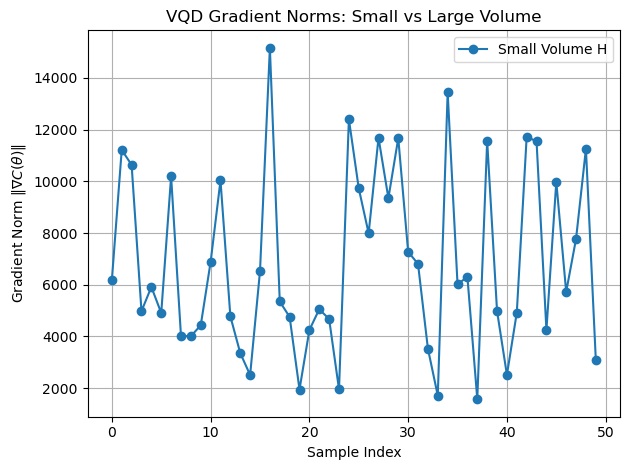

In [50]:
plt.plot(norms_small, label='Small Volume H', marker='o')
plt.xlabel("Sample Index")
plt.ylabel("Gradient Norm $\\|\\nabla C(\\theta)\\|$")
plt.title("VQD Gradient Norms: Small vs Large Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(array([6., 8., 7., 4., 6., 7., 8., 1., 2., 1.]),
 array([ 1505.72146533,  2910.72541931,  4315.7293733 ,  5720.73332729,
         7125.73728127,  8530.74123526,  9935.74518924, 11340.74914323,
        12745.75309722, 14150.7570512 , 15555.76100519]),
 <BarContainer object of 10 artists>)

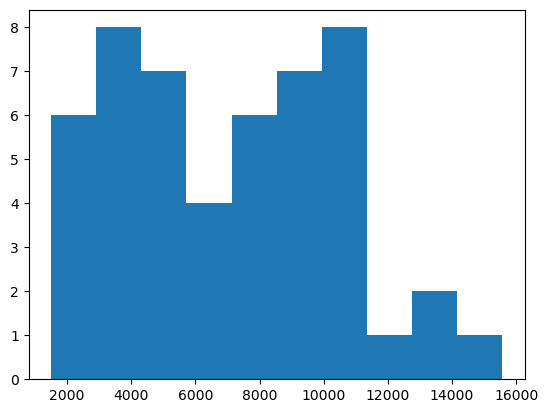

In [44]:
plt.hist(norms_small)

The Schlogl operator matrix is:
[[  -0.275         2.95          0.            0.            0.
     0.            0.            0.        ]
 [   0.275        -3.225         5.9           0.            0.
     0.            0.            0.        ]
 [   0.            0.275       -11.62954545   11.82520661    0.
     0.            0.            0.        ]
 [   0.            0.            5.72954545  -28.46384298   23.70082645
     0.            0.            0.        ]
 [   0.            0.            0.           16.63863636  -56.70309917
    44.50206612    0.            0.        ]
 [   0.            0.            0.            0.           33.00227273
   -99.32252066   77.20413223    0.        ]
 [   0.            0.            0.            0.            0.
    54.82045455 -159.29731405  124.7822314 ]
 [   0.            0.            0.            0.            0.
     0.           82.09318182 -124.7822314 ]]

The volume parameter is:
1.1

The Hermitian form of the Schlogl matrix

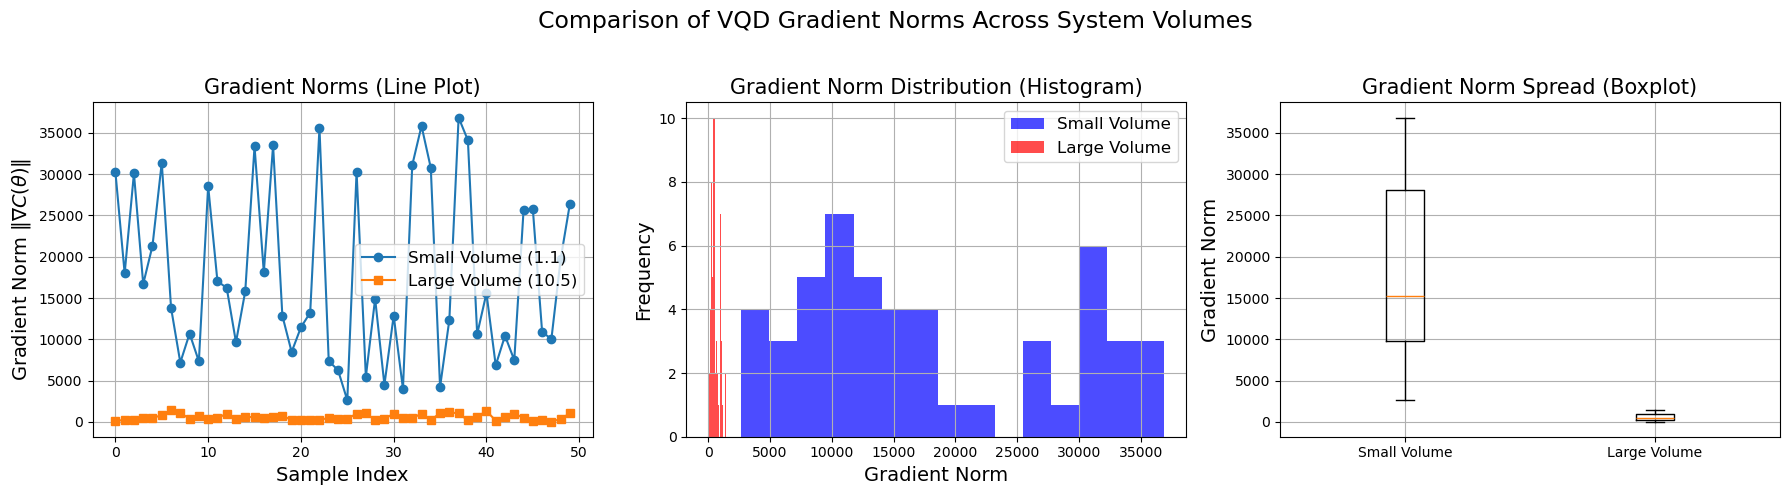

Small Volume:  mean = 17678.2843, std = 10298.0154
Large Volume:  mean = 578.6883, std = 348.0749


In [58]:
# Gradient norm computation function
def compute_gradient_norms(hamiltonian, ansatz, psi_0, beta, num_samples=50):
    estimator = Estimator()
    grad = ParamShiftEstimatorGradient(estimator)
    hamiltonian_qiskit = SparsePauliOp.from_operator(Operator(hamiltonian))
    
    norms = []
    for _ in range(num_samples):
        theta = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
        
        # Deflated observable: H + beta * |psi_0><psi_0|
        psi_0_ket = Statevector(psi_0)
        projector = psi_0_ket.to_operator()
        projector_qiskit = SparsePauliOp.from_operator(projector)
        deflated_H = hamiltonian_qiskit + beta * projector_qiskit
        
        result = grad.run(
            [ansatz],
            [deflated_H],
            [theta]
        ).result()

        norm = np.linalg.norm(result.gradients[0])
        norms.append(norm)
    
    return norms

# --- System Setup ---
# Assume get_zeromode returns (Q, H, psi0) for given num_qubits and volume
num_qubits = 3
beta = 10
num_samples = 50

# Get small and large volume data
Q_small, H_small, psi0_small = get_zeromode(num_qubits, 1.1)
Q_large, H_large, psi0_large = get_zeromode(num_qubits, 10.5)

# Create ansatz for 3 qubits
ansatz = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=1)

# Compute gradient norms
norms_small = compute_gradient_norms(H_small, ansatz, psi0_small, beta, num_samples)
norms_large = compute_gradient_norms(H_large, ansatz, psi0_large, beta, num_samples)

# --- Visualization ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Line Plot
axs[0].plot(norms_small, label='Small Volume (1.1)', marker='o')
axs[0].plot(norms_large, label='Large Volume (10.5)', marker='s')
axs[0].set_xlabel("Sample Index", fontsize=14)
axs[0].set_ylabel("Gradient Norm $\\|\\nabla C(\\theta)\\|$", fontsize=14)
axs[0].set_title("Gradient Norms (Line Plot)", fontsize=15)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# 2. Histogram
axs[1].hist(norms_small, bins=15, alpha=0.7, label='Small Volume', color='blue')
axs[1].hist(norms_large, bins=15, alpha=0.7, label='Large Volume', color='red')
axs[1].set_xlabel("Gradient Norm", fontsize=14)
axs[1].set_ylabel("Frequency", fontsize=14)
axs[1].set_title("Gradient Norm Distribution (Histogram)", fontsize=15)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# 3. Boxplot
axs[2].boxplot([norms_small, norms_large], labels=['Small Volume', 'Large Volume'])
axs[2].set_ylabel("Gradient Norm", fontsize=14)
axs[2].set_title("Gradient Norm Spread (Boxplot)", fontsize=15)
axs[2].grid(True)

plt.suptitle("Comparison of VQD Gradient Norms Across System Volumes", fontsize=17)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Optional: Print Stats ---
mean_small, std_small = np.mean(norms_small), np.std(norms_small)
mean_large, std_large = np.mean(norms_large), np.std(norms_large)

print(f"Small Volume:  mean = {mean_small:.4f}, std = {std_small:.4f}")
print(f"Large Volume:  mean = {mean_large:.4f}, std = {std_large:.4f}")